In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Reading data and creating the ratings matrix
df = pd.read_csv('ratings.csv')

In [3]:
# Filter sparse movies
min_movie_ratings = 10
filter_movies = (df['movieId'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 10
filter_users = (df['userId'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings

In [4]:
# Shuffle DataFrame
df = df.drop('timestamp', axis=1).sample(frac=1).reset_index(drop=True)
df.head()

,userId,movieId,rating
0,397,1077,4.0
1,590,2028,4.0
2,141,6934,3.5
3,365,58559,3.5
4,288,2662,3.0


In [5]:
from sklearn.model_selection import train_test_split
df_train , df_test = train_test_split(df, test_size = 0.2)
ratings = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
ratings[ratings.isnull()] = -1
ratings=torch.FloatTensor(ratings.values)
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
if(min(torch.sum(non_zero_mask,1))==0):
    print('Do another split')
else:
    print(f"Min no of rating by a user in train set: {min(torch.sum(non_zero_mask,1))}")      

Min no of rating by a user in train set: 5.0


In [6]:
ratings = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')

#Scaling
min_rating, max_rating = df['rating'].min(), df['rating'].max()
ratings = (ratings - min_rating) / (max_rating - min_rating)

ratings[ratings.isnull()] = -1
ratings = torch.FloatTensor(ratings.values)
ratings = ratings

ratings_original = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
ratings_original[ratings_original.isnull()] = -1
ratings_original = torch.FloatTensor(ratings_original.values)
ratings_original = ratings_original


rate2 = pd.pivot_table(df, index = 'userId', columns = 'movieId', values = 'rating')
rate2 = torch.FloatTensor(rate2.values)
rate2 = rate2

rate = pd.pivot_table(df_train, index = 'userId', columns = 'movieId', values = 'rating')
rate[rate.isnull()] = -1
rate[rate >= 0] = np.nan
rate = rate + 1
rate = torch.FloatTensor(rate.values)
rate = rate

test = rate2 - rate
test[torch.isnan(test)] = -1

n_users, n_movies = ratings.shape

#### Biased PMF

In [16]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class BiasedPMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
    
    def forward(self, matrix, u_features, v_features, u_bias, v_bias):
        n_users,n_movies=matrix.shape
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        bias=u_bias.repeat(1,n_movies)+v_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(u_features, v_features.t()))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * (torch.sum(u_features.norm(dim=1)**2)+u_bias.norm()**2)
        v_regularization = self.lam_v * (torch.sum(v_features.norm(dim=1)**2)+v_bias.norm()**2)
        
        return prediction_error + u_regularization + v_regularization

In [146]:
latent_vectors, lam_u, lam_v = 50, 0.42, 0.42
user_features = torch.randn(n_users, latent_vectors, requires_grad=True)
user_features.data.mul_(0.01)
movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
movie_features.data.mul_(0.01)
user_bias = torch.randn(n_users, 1, requires_grad=True)
user_bias.data.mul_(0.01)
movie_bias = torch.randn(1,n_movies, requires_grad=True)
movie_bias.data.mul_(0.01)

PMF_model = BiasedPMFLoss(lam_u, lam_v)
optimizer = torch.optim.Adam([user_features, movie_features, user_bias, movie_bias], lr=0.01)

rmse_train=[]
rmse_test=[]
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)

non_zero_mask_test = (test != -1).type(torch.FloatTensor)
for step, epoch in enumerate(range(2000)):
    optimizer.zero_grad()
    loss = PMF_model(ratings, user_features, movie_features, user_bias, movie_bias)
    loss.backward()
    optimizer.step()
    
    bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
    predicted = torch.sigmoid(bias+torch.mm(user_features, movie_features.t()))
    predicted = (predicted*(max_rating - min_rating) + min_rating)
    rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
    rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())
    
    if step % 500 == 0:
        print(f"Step {step}, {loss:.3f}")

Step 0, 5417.881
Step 500, 1890.789
Step 1000, 1890.399
Step 1500, 1890.372


In [147]:
#Training error
bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
predicted = torch.sigmoid(bias+torch.mm(user_features, movie_features.t()))
predicted = (predicted*(max_rating - min_rating) + min_rating)

non_zero_mask = (ratings != -1).type(torch.FloatTensor)
torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))

tensor(0.5507, grad_fn=<SqrtBackward>)

In [148]:
#Testing Error
non_zero_mask = (test != -1).type(torch.FloatTensor)
torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask)/len(df_test))

tensor(0.8297, grad_fn=<SqrtBackward>)

In [149]:
#rmse_train25=rmse_train
#rmse_test25=rmse_test
if latent_vectors==5:
    rmse_train5=rmse_train
    rmse_test5=rmse_test
elif latent_vectors==25:
    rmse_train25=rmse_train
    rmse_test25=rmse_test
elif latent_vectors==50:
    rmse_train50=rmse_train
    rmse_test50=rmse_test    

Text(0.5, 0.98, 'Biased PMF')

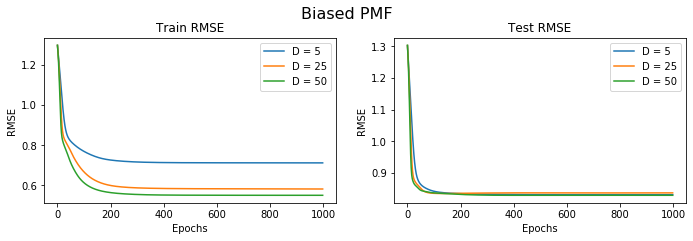

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(rmse_train5, label="D = 5")
ax1.plot(rmse_train25, label="D = 25")
ax1.plot(rmse_train50, label="D = 50")
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(rmse_test5, label="D = 5")
ax2.plot(rmse_test25, label="D = 25")
ax2.plot(rmse_test50, label="D = 50")
ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Biased PMF', fontsize=16)

#### Constrained PMF

In [151]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class ConstrainedPMFLoss(torch.nn.Module):
    def __init__(self, lam_y=0.4, lam_w=0.4, lam_v=0.3):
        super().__init__()
        self.lam_y = lam_y
        self.lam_w = lam_w
        self.lam_v = lam_v
    
    def forward(self, matrix, Y, W, v_features):
        n_users,n_movies=matrix.shape
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        #u_features= (Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1).repeat(1,latent_vectors))
        predicted = torch.sigmoid(torch.mm((Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1)), v_features.t()))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        y_regularization = self.lam_y * torch.sum(Y.norm(dim=1)**2)
        w_regularization = self.lam_w * torch.sum(W.norm(dim=1)**2)
        v_regularization = self.lam_v * torch.sum(v_features.norm(dim=1)**2)
        
        return prediction_error + y_regularization + w_regularization + v_regularization

In [152]:
latent_vectors, lam_y, lam_w, lam_v = 50, 0.5, 0.5, 0.5
Y = torch.randn(n_users, latent_vectors, requires_grad=True)
Y.data.mul_(0.01)
W = torch.randn(n_movies, latent_vectors, requires_grad=True)
W.data.mul_(0.01)
movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
movie_features.data.mul_(0.01)

PMF_model = ConstrainedPMFLoss(lam_y, lam_w, lam_v)
optimizer = torch.optim.Adam([Y, W, movie_features], lr=0.01)

rmse_train=[]
rmse_test=[]
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)

for step, epoch in enumerate(range(2000)):
    optimizer.zero_grad()
    loss = PMF_model(ratings, Y, W, movie_features)
    loss.backward()
    optimizer.step()
    
    predicted = (torch.sigmoid(torch.mm((Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1)), movie_features.t())))
    predicted = (predicted*(max_rating - min_rating) + min_rating)
    rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
    rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())
    
    if step % 500 == 0:
        print(f"Step {step}, {loss:.3f}")

Step 0, 5420.492
Step 500, 2469.669
Step 1000, 2469.249
Step 1500, 2469.229


In [153]:
#Training error
#u_features = (Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1).repeat(1,latent_vectors))
predicted = (torch.sigmoid(torch.mm((Y+torch.mm(non_zero_mask, W)/torch.sum(non_zero_mask,1).view(n_users,1)), movie_features.t())))
predicted = (predicted*(max_rating - min_rating) + min_rating)

torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))

tensor(0.6154, grad_fn=<SqrtBackward>)

In [154]:
#Testing Error
torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))

tensor(0.8510, grad_fn=<SqrtBackward>)

In [155]:
if latent_vectors==5:
    rmse_train5=rmse_train
    rmse_test5=rmse_test
elif latent_vectors==25:
    rmse_train25=rmse_train
    rmse_test25=rmse_test
elif latent_vectors==50:
    rmse_train50=rmse_train
    rmse_test50=rmse_test    

Text(0.5, 0.98, 'Constrained PMF')

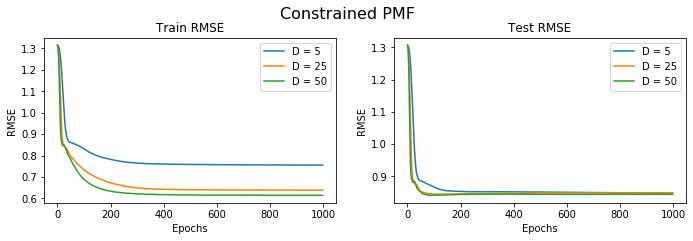

In [140]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(rmse_train5, label="D = 5")
ax1.plot(rmse_train25, label="D = 25")
ax1.plot(rmse_train50, label="D = 50")
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(rmse_test5, label="D = 5")
ax2.plot(rmse_test25, label="D = 25")
ax2.plot(rmse_test50, label="D = 50")
ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Constrained PMF', fontsize=16)

#### Biased Deep PMF

In [44]:
import torch.nn.functional as F

In [45]:
#Instead of returning the prediction, this returns the loss directly in the forward prop
class BiasedDeepPMFLoss(torch.nn.Module):
    def __init__(self, lam_u=0.3, lam_v=0.3, lam_d=0.5):
        super().__init__()
        self.lam_u = lam_u
        self.lam_v = lam_v
        self.lam_d = lam_d
    
    def forward(self, matrix, u_features, v_features, u_bias, v_bias, dense1):
        non_zero_mask = (matrix != -1).type(torch.FloatTensor)
        output1=F.relu(torch.mm(u_features, v_features.t()))
        bias=u_bias.repeat(1,n_movies)+v_bias.repeat(n_users,1)
        predicted = torch.sigmoid(bias+torch.mm(output1, dense1))
        
        diff = ((matrix - predicted)**2)
        prediction_error = torch.sum(diff*non_zero_mask)

        u_regularization = self.lam_u * (torch.sum(u_features.norm(dim=1)**2) + u_bias.norm()**2)
        v_regularization = self.lam_v * (torch.sum(v_features.norm(dim=1)**2) + v_bias.norm()**2)
        d_regularization = self.lam_d * (torch.sum(dense1.norm(dim=1)**2))
        
        return prediction_error + u_regularization + v_regularization + d_regularization

In [136]:
latent_vectors, lam_u, lam_v, lam_d = 50, 0.3, 0.3, 40
user_features = torch.randn(n_users, latent_vectors, requires_grad=True)
user_features.data.mul_(0.01)
movie_features = torch.randn(n_movies, latent_vectors, requires_grad=True)
movie_features.data.mul_(0.01)
user_bias = torch.randn(n_users, 1, requires_grad=True)
user_bias.data.mul_(0.01)
movie_bias = torch.randn(1,n_movies, requires_grad=True)
movie_bias.data.mul_(0.01)
dense1=torch.randn(n_movies, n_movies, requires_grad=True)
#dense1.data.mul_(0.01)

PMF_model = BiasedDeepPMFLoss(lam_u, lam_v, lam_d)
optimizer = torch.optim.Adam([user_features, movie_features, user_bias, movie_bias, dense1], lr=0.01)

rmse_train=[]
rmse_test=[]
non_zero_mask = (ratings != -1).type(torch.FloatTensor)
non_zero_mask_test = (test != -1).type(torch.FloatTensor)

for step, epoch in enumerate(range(2000)):
    optimizer.zero_grad()
    loss = PMF_model(ratings, user_features, movie_features, user_bias, movie_bias, dense1)
    loss.backward()
    optimizer.step()
    
    output1=F.relu(torch.mm(user_features, movie_features.t()))
    bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
    predicted = torch.sigmoid(bias+torch.mm(output1, dense1))
    predicted = (predicted*(max_rating - min_rating) + min_rating)
    rmse_train.append((torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))).item())
    rmse_test.append((torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))).item())
    
    if step % 500 == 0:
        print(f"Step {step}, {loss:.3f}")

Step 0, 179806704.000
Step 500, 82588.820
Step 1000, 2243.718
Step 1500, 2192.844


In [137]:
#Training error
output1=F.relu(torch.mm(user_features, movie_features.t()))
bias=user_bias.repeat(1,n_movies)+movie_bias.repeat(n_users,1)
predicted = torch.sigmoid(bias+torch.mm(output1, dense1))
predicted = (predicted*(max_rating - min_rating) + min_rating)

torch.sqrt(torch.sum(((predicted - ratings_original) ** 2) * non_zero_mask)/len(df_train))

tensor(0.6922, grad_fn=<SqrtBackward>)

In [138]:
#Testing Error
torch.sqrt(torch.sum(((predicted - test) ** 2) * non_zero_mask_test)/len(df_test))

tensor(0.8299, grad_fn=<SqrtBackward>)

In [141]:
if latent_vectors==5:
    rmse_train5=rmse_train
    rmse_test5=rmse_test
elif latent_vectors==25:
    rmse_train25=rmse_train
    rmse_test25=rmse_test
elif latent_vectors==50:
    rmse_train50=rmse_train
    rmse_test50=rmse_test  

Text(0.5, 0.98, 'Deep PMF')

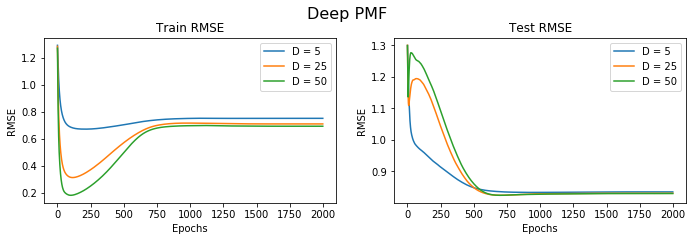

In [142]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3.5))
ax1.plot(rmse_train5, label="D = 5")
ax1.plot(rmse_train25, label="D = 25")
ax1.plot(rmse_train50, label="D = 50")
ax1.set_title('Train RMSE')
ax1.set(xlabel='Epochs', ylabel='RMSE')
ax1.legend()
ax2.plot(rmse_test5, label="D = 5")
ax2.plot(rmse_test25, label="D = 25")
ax2.plot(rmse_test50, label="D = 50")
ax2.set_title('Test RMSE')
ax2.set(xlabel='Epochs', ylabel='RMSE')
ax2.legend()

fig.tight_layout(pad=2.0)
fig.suptitle('Deep PMF', fontsize=16)